In [1]:
# Projective Objective
# Computing the beta for 3 stocks and performance on each one of them based how well they fair against the average return of the market
# We will use SPY as the benchmarket as it tracks the top 500 companies in the market for united states

In [2]:
# Import all necessary libraries
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import alpaca_trade_api as tradeapi
import requests
import os
%matplotlib inline

In [3]:
# Load env variable
load_dotenv("env.txt")

True

In [6]:
# Load alpaca keys
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [7]:
# Set up request to Alpaca
alpaca_request = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [8]:
# Set up timeframe and timezone
start = pd.Timestamp("2019-01-01", tz="America/New_York").isoformat()
end = pd.Timestamp("2023-07-12", tz="America/New_York").isoformat()

timeframe = "1D"

In [10]:
# Set up tickers
tickers = ["MSFT","ENB","JPM","SPY"]

In [11]:
# Send request to Alpaca
df_portfolio = alpaca_request.get_bars(
    tickers,
    timeframe,
    start = start,
    end = end
).df

In [12]:
# Check dataframe df_portfolio
df_portfolio.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2019-01-02 05:00:00+00:00,30.74,31.88,30.540,31.58,3921511,24167,31.461711,ENB
2019-01-03 05:00:00+00:00,31.56,31.95,31.210,31.75,4681524,25492,31.639112,ENB
2019-01-04 05:00:00+00:00,32.18,32.67,32.080,32.62,4488880,26727,32.481863,ENB
2019-01-07 05:00:00+00:00,33.00,33.64,32.755,33.51,6377444,33125,33.352460,ENB
2019-01-08 05:00:00+00:00,33.85,34.43,33.810,34.20,5769507,32734,34.196518,ENB


In [13]:
# Check for null data
df_portfolio.isnull().mean()*100

open           0.0
high           0.0
low            0.0
close          0.0
volume         0.0
trade_count    0.0
vwap           0.0
symbol         0.0
dtype: float64

In [15]:
# Seperate each stock into its own dataframe
msft_df = df_portfolio.loc[df_portfolio["symbol"]=="MSFT"].drop(columns=["open","high","low","volume","trade_count","vwap","symbol"])
enb_df = df_portfolio.loc[df_portfolio["symbol"]=="ENB"].drop(columns=["open","high","low","volume","trade_count","vwap","symbol"])
jpm_df = df_portfolio.loc[df_portfolio["symbol"]=="JPM"].drop(columns=["open","high","low","volume","trade_count","vwap","symbol"])
spy_df = df_portfolio.loc[df_portfolio["symbol"]=="SPY"].drop(columns=["open","high","low","volume","trade_count","vwap","symbol"])

In [16]:
# Rename column for each dataframe
msft_df.columns = ["MSFT"]
enb_df.columns = ["ENB"]
jpm_df.columns = ["JPM"]
spy_df.columns = ["SPY"]

In [17]:
# Concatenate the dataframes into a combined dataframe
df_portfolio_combined = pd.concat([msft_df,enb_df,jpm_df,spy_df], axis="columns", join="inner")

In [18]:
# Check dataframe
df_portfolio_combined.head()

,MSFT,ENB,JPM,SPY
timestamp,,,,
2019-01-02 05:00:00+00:00,101.12,31.58,99.31,250.23
2019-01-03 05:00:00+00:00,97.40,31.75,97.11,244.15
2019-01-04 05:00:00+00:00,101.93,32.62,100.69,252.39
2019-01-07 05:00:00+00:00,102.06,33.51,100.76,254.29
2019-01-08 05:00:00+00:00,102.80,34.20,100.57,256.62


In [19]:
# Compute for daily percentage change
daily_return = df_portfolio_combined.pct_change().dropna()

# Check dataframe
daily_return.head()

,MSFT,ENB,JPM,SPY
timestamp,,,,
2019-01-03 05:00:00+00:00,-0.036788,0.005383,-0.022153,-0.024298
2019-01-04 05:00:00+00:00,0.046509,0.027402,0.036865,0.033750
2019-01-07 05:00:00+00:00,0.001275,0.027284,0.000695,0.007528
2019-01-08 05:00:00+00:00,0.007251,0.020591,-0.001886,0.009163
2019-01-09 05:00:00+00:00,0.014300,0.008187,-0.001690,0.005066


In [21]:
# Compute rolling covariance for each stock except for SPY
msft_rolling_covariance = daily_return["MSFT"].rolling(window=30).cov(daily_return["SPY"])
enb_rolling_covariance = daily_return["ENB"].rolling(window=30).cov(daily_return["SPY"])
jpm_rolling_covariance = daily_return["JPM"].rolling(window=30).cov(daily_return["SPY"])

# Compute roling variance for SPY
spy_rolling_variance = daily_return["SPY"].rolling(window=30).var()

In [22]:
# Compute for Rolling Beta for each stock
msft_rolling_beta = msft_rolling_covariance/spy_rolling_variance
enb_rolling_beta = enb_rolling_covariance/spy_rolling_variance
jpm_rolling_beta = jpm_rolling_covariance/spy_rolling_variance

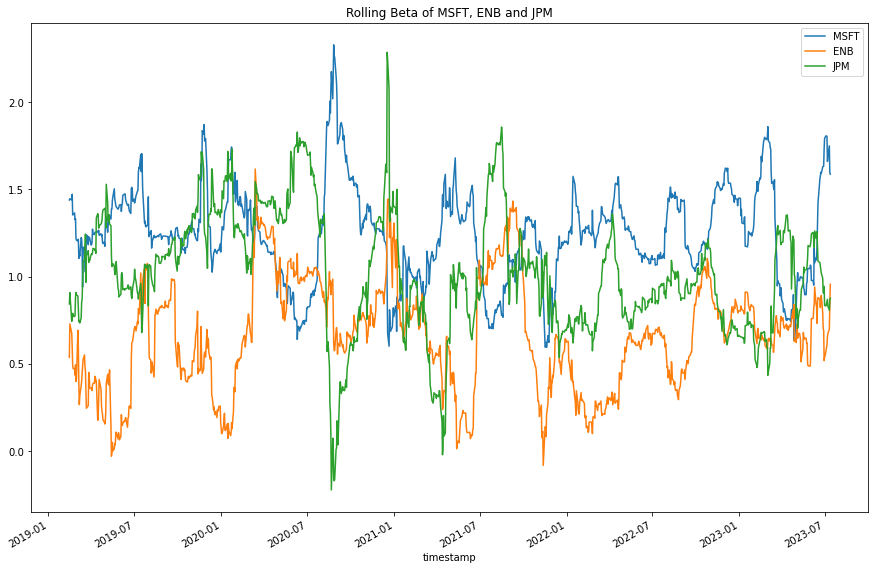

In [24]:
# Plot and overlay the rolling covariance of each stock
ax = msft_rolling_beta.plot(figsize=(15,10), title="Rolling Beta of MSFT, ENB and JPM")

enb_rolling_beta.plot(ax=ax)
jpm_rolling_beta.plot(ax=ax)

ax.legend(["MSFT","ENB","JPM"])

In [25]:
jpm_rolling_beta.min()

-0.2219776205607903

In [28]:
jpm_rolling_beta.mean()

1.0214786355382353

In [26]:
enb_rolling_beta.min()

-0.08161469224711776

In [29]:
enb_rolling_beta.mean()

0.6587024028048618

In [27]:
msft_rolling_beta.min()

0.5943062199152276

In [30]:
msft_rolling_beta.mean()

1.2407476834934925

In [32]:
# Out of the 3 stocks, only msft never had negative return compared to the overall market, and is generally yielding 1.24x average return than the overall market. 